In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GradExplainer, GNNExplainer, PGMExplainer, GraphLIME
from graphxai.metrics.base import graph_exp_acc, graph_exp_faith
from torch_geometric.utils import k_hop_subgraph
import networkx as nx
from graphxai.utils import Explanation, EnclosingSubgraph
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from torch_geometric.data import Data

In [37]:
# Generate dataset ShapeGGen
dataset = ShapeGGen(model_layers=3, num_graphs=1, make_explanations=True)
# Ambil graph dari dataset
data = dataset.graph  # Dataset hanya memiliki satu graf
explanation = dataset.explanations  # atau mungkin dataset.explanations jika atributnya berbentuk list

print(f"Graph Data: {data}")
print(f"Graph Explanations: {explanation}")
print(f"Explanation Available: {'Yes' if explanation is not None else 'No'}")

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 77.80it/s] 


Graph Data: Data(x=[140, 11], edge_index=[2, 390], y=[140], shape=[140])
Graph Explanations: [[<graphxai.utils.explanation.Explanation object at 0x000002AB89699E50>], [<graphxai.utils.explanation.Explanation object at 0x000002AB896991F0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F9190>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F98E0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F99A0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F99D0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F90A0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F9AF0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F9310>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F9F70>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F9CD0>], [<graphxai.utils.explanation.Explanation object at 0x000002ABEC5F9A30>], [<graphxai.utils.explanation.E

In [19]:
print(data.keys)

['train_mask', 'val_mask', 'y', 'shape', 'x', 'edge_index']


In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
from graphxai.gnn_models.node_classification.gcn import GCN

# Asumsi data ShapeGGen tersedia di dataset.graph
data = dataset.graph
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(torch.unique(data.y))

# Inisialisasi model dan optimizer
model = GCN(hidden_channels=32, input_feat=data.num_node_features, classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Split mask
num_nodes = data.x.shape[0]
perm = torch.randperm(num_nodes)
split_idx = int(0.8 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:split_idx]] = True
val_mask[perm[split_idx:]] = True

# Fungsi training
def train(model, data, optimizer, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = F.cross_entropy(out[train_mask], data.y[train_mask].to(device))
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=1)
    acc = (pred[train_mask] == data.y[train_mask].to(device)).float().mean().item()
    return loss.item(), acc

# Fungsi validasi
def validate(model, data, val_mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = F.cross_entropy(out[val_mask], data.y[val_mask].to(device))
        pred = out.argmax(dim=1)
        acc = (pred[val_mask] == data.y[val_mask].to(device)).float().mean().item()
    return loss.item(), acc

# Training loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
patience, trigger_times = 10, 0

for epoch in range(200):
    train_loss, train_acc = train(model, data, optimizer, train_mask)
    val_loss, val_acc = validate(model, data, val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:03d}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f} | Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping triggered.")
        break


Epoch 001: Train Loss = 0.6576 | Val Loss = 0.6364 | Train Acc = 0.6071 | Val Acc = 0.6071
Epoch 002: Train Loss = 0.6495 | Val Loss = 0.6126 | Train Acc = 0.6161 | Val Acc = 0.6429
Epoch 003: Train Loss = 0.6172 | Val Loss = 0.5924 | Train Acc = 0.6429 | Val Acc = 0.6786
Epoch 004: Train Loss = 0.5973 | Val Loss = 0.5780 | Train Acc = 0.6518 | Val Acc = 0.6786
Epoch 005: Train Loss = 0.5953 | Val Loss = 0.5658 | Train Acc = 0.6696 | Val Acc = 0.6429
Epoch 006: Train Loss = 0.5763 | Val Loss = 0.5561 | Train Acc = 0.7143 | Val Acc = 0.6786
Epoch 007: Train Loss = 0.5495 | Val Loss = 0.5483 | Train Acc = 0.7143 | Val Acc = 0.6786
Epoch 008: Train Loss = 0.5777 | Val Loss = 0.5421 | Train Acc = 0.7232 | Val Acc = 0.6786
Epoch 009: Train Loss = 0.5561 | Val Loss = 0.5368 | Train Acc = 0.7054 | Val Acc = 0.6786
Epoch 010: Train Loss = 0.5661 | Val Loss = 0.5325 | Train Acc = 0.7321 | Val Acc = 0.7143
Epoch 011: Train Loss = 0.5385 | Val Loss = 0.5285 | Train Acc = 0.7411 | Val Acc = 0.6786

In [55]:
class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        # Pastikan model ada di device yang benar (kalau CPU/GPU beda)
        self.model = self.model.to(x.device)

        # Panggil GraphLIME asli, tapi log sebelum dan sesudah
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")

        return result


# Inisialisasi explainer
grad_explainer = GradExplainer(model, criterion=F.nll_loss)
gnn_explainer = GNNExplainer(model)
pgm_explainer = PGMExplainer(model, explain_graph=False)
lime_explainer = SafeGraphLIME(model)

# Ambil satu node untuk dijelaskan
node_idx = 10  # Pastikan node ini valid dan ada di train mask
x, edge_index = data.x, data.edge_index
# === Ambil Subgraph k-hop (khusus Grad dan GNN) ===
num_hops = 2
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_idx, num_hops, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
)
sub_x = data.x[subset]

# Grad dan GNN pakai subgraph
grad_explanation = grad_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)
gnn_explanation = gnn_explainer.get_explanation_node(mapping, sub_x, sub_edge_index)

# PGM dan GraphLIME pakai full graph
x, edge_index = dataset.graph.x, dataset.graph.edge_index
print(f"Check sebelum GraphLIME:")
print(f"x shape: {x.shape}")
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_index max node id: {edge_index.max().item()}")

assert x.shape[0] > edge_index.max().item(), "Jumlah node di x tidak sesuai edge_index!"

pgm_explanation = pgm_explainer.get_explanation_node(node_idx, x, edge_index)
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)


Check sebelum GraphLIME:
x shape: torch.Size([140, 11])
edge_index shape: torch.Size([2, 390])
edge_index max node id: 139


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [56]:
# Ground truth explanation dari ShapeGGen
ground_truth = dataset.explanations[node_idx][0]  # Extract the Explanation object from the list

# Evaluasi Graph Explanation Accuracy (GEA)
gea_grad = graph_exp_acc(ground_truth, grad_explanation)
gea_gnn = graph_exp_acc(ground_truth, gnn_explanation)
gea_pgm = graph_exp_acc(ground_truth, pgm_explanation)
# khusus LIME (karena lebih ke feature importance bukan node jadi di konversi ke node)
# Dapatkan feature importance dari GraphLIME
lime_explanation = lime_explainer.get_explanation_node(node_idx, x, edge_index)

# Konversi feature importance GraphLIME ke node importance
node_importance = lime_explanation.feature_imp.mean().item()
lime_node_importance = torch.zeros(data.num_nodes)  # Untuk full graph
lime_node_importance[node_idx] = node_importance

# Buat node_reference lengkap untuk full graph
node_reference = {i: i for i in range(data.num_nodes)}

# Buat edge_mask manual (untuk mendukung versi lama torch_geometric)
edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
for edge_id, (src, dst) in enumerate(data.edge_index.T):
    if src in subset and dst in subset:
        edge_mask[edge_id] = True

class ExplanationCompat(Explanation):
    def __init__(self, enc_subgraph=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.enc_subgraph = enc_subgraph

lime_exp = ExplanationCompat(
    node_imp=lime_node_importance,
    node_idx=node_idx,
    enc_subgraph=EnclosingSubgraph(
        nodes=subset,
        edge_index=sub_edge_index,
        inv=mapping,
        edge_mask=edge_mask,
        directed=False
    )
)

lime_exp.node_reference = node_reference  # Ini kunci utama!
gea_lime = graph_exp_acc(ground_truth, lime_exp)

print("Graph Explanation Accuracy:")
print(f"Grad: {gea_grad:.4f}")
print(f"GNNExplainer: {gea_gnn:.4f}")
print(f"PGMExplainer: {gea_pgm:.4f}")
print(f"GraphLIME: {gea_lime:.4f}")

# Evaluasi Graph Explanation Faithfulness (GEF)
gef_grad = graph_exp_faith(grad_explanation, dataset, model)
gef_gnn = graph_exp_faith(gnn_explanation, dataset, model)
gef_pgm = graph_exp_faith(pgm_explanation, dataset, model)
gef_lime = graph_exp_faith(lime_exp, dataset, model)
print("\nGraph Explanation Faithfulness:")
print(f"Grad: {gef_grad:.4f}")
print(f"GNNExplainer: {gef_gnn:.4f}")
print(f"PGMExplainer: {gef_pgm:.4f}")
print(f"GraphLIME: {gef_lime:.4f}")

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10
Graph Explanation Accuracy:
Grad: 0.0000
GNNExplainer: 0.3000
PGMExplainer: 0.0000
GraphLIME: 0.0000

Graph Explanation Faithfulness:
Grad: 1.0000
GNNExplainer: 1.0000
PGMExplainer: 1.0000
GraphLIME: 1.0000


c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


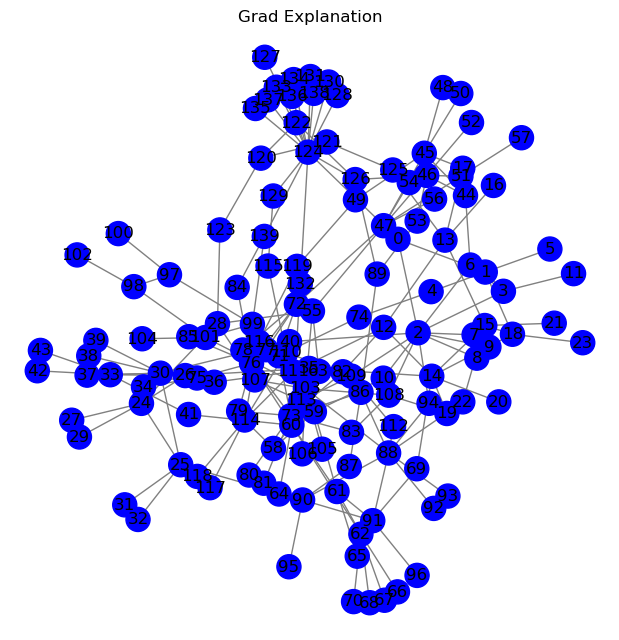

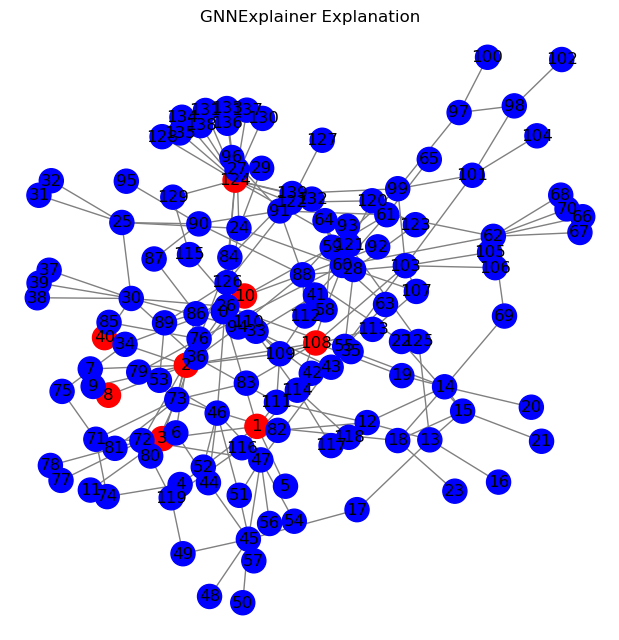

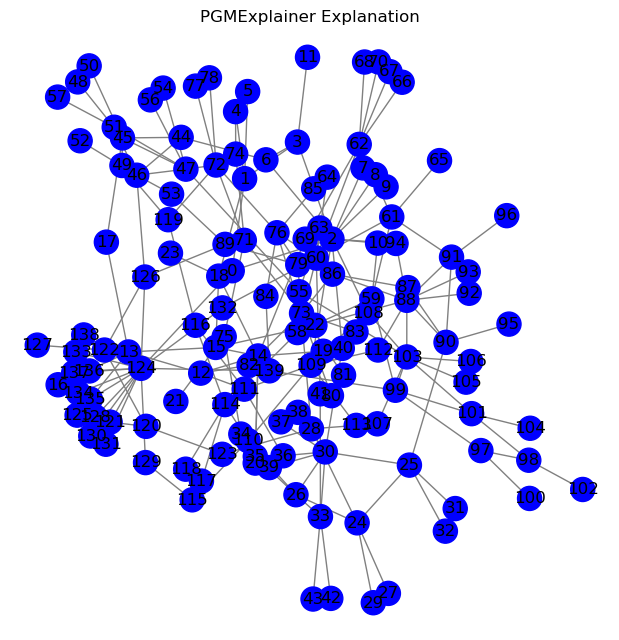

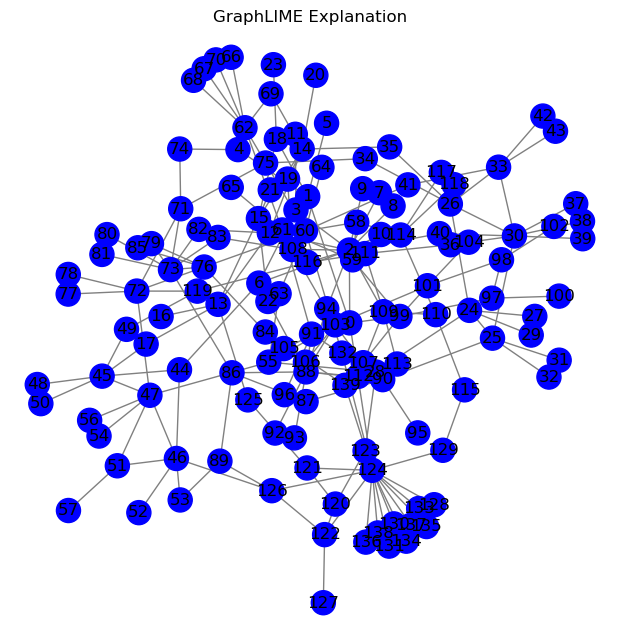

In [57]:
def visualize_explanation(graph, node_idx, explanation, title):
    plt.figure(figsize=(6, 6))
    G = nx.Graph()
    edges = graph.edge_index.cpu().numpy()
    for i in range(edges.shape[1]):
        G.add_edge(edges[0, i], edges[1, i])

    # Create a default color list for all nodes (blue)
    num_nodes = graph.x.size(0)
    node_colors = ['blue'] * num_nodes
    
    # Update colors based on node importance scores
    for node, imp in explanation.node_reference.items():
        if imp < len(explanation.node_imp):
            node_colors[node] = 'red' if explanation.node_imp[imp] > 0 else 'blue'

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray")
    plt.title(title)
    plt.show()


# Visualisasi hasil explainability
visualize_explanation(data, node_idx, grad_explanation, "Grad Explanation")
visualize_explanation(data, node_idx, gnn_explanation, "GNNExplainer Explanation")
visualize_explanation(data, node_idx, pgm_explanation, "PGMExplainer Explanation")
visualize_explanation(data, node_idx, pgm_explanation, "GraphLIME Explanation")

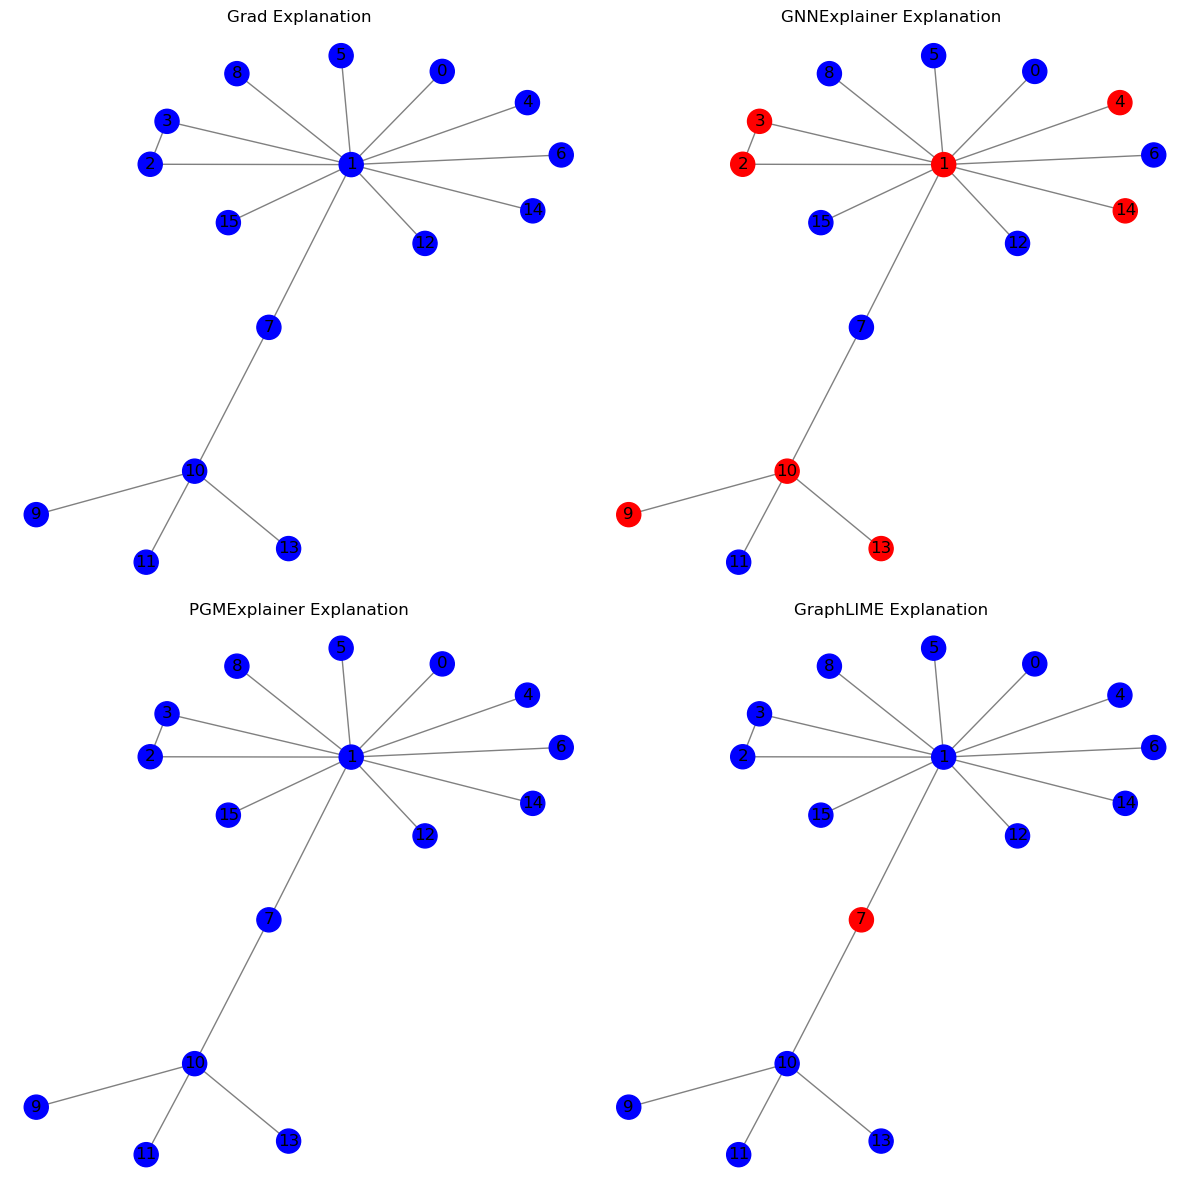

In [58]:
lime_node_importance = torch.zeros(len(subset))

# Cari posisi node_idx di subset
node_idx_in_subgraph = (subset == node_idx).nonzero(as_tuple=True)[0].item()

# Isi importance hanya untuk node yang dijelaskan
lime_node_importance[node_idx_in_subgraph] = node_importance

def visualize_all_explanations_subgraph(graph, node_idx, grad_exp, gnn_exp, pgm_exp, lime_exp, subset, sub_edge_index):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    explanations = [
        ("Grad Explanation", grad_exp),
        ("GNNExplainer Explanation", gnn_exp),
        ("PGMExplainer Explanation", pgm_exp),
        ("GraphLIME Explanation", lime_exp)
    ]

    for ax, (title, explanation) in zip(axs.flat, explanations):
        visualize_explanation_subgraph(graph, node_idx, explanation, title, ax, subset, sub_edge_index)

    plt.tight_layout()
    plt.show()

def visualize_explanation_subgraph(graph, node_idx, explanation, title, ax, subset, sub_edge_index):
    G = nx.Graph()
    for i in range(sub_edge_index.shape[1]):
        src, dst = sub_edge_index[:, i]
        G.add_edge(src.item(), dst.item())

    node_colors = ['blue'] * len(subset)

    if explanation.node_imp.shape[0] == len(subset):
        # Langsung pakai (Grad, GNN, PGM)
        for local_idx, imp in enumerate(explanation.node_imp):
            node_colors[local_idx] = 'red' if imp > 0 else 'blue'
    else:
        # Khusus untuk GraphLIME (importance full graph)
        node_idx_in_subgraph = (subset == node_idx).nonzero(as_tuple=True)[0].item()
        node_colors[node_idx_in_subgraph] = 'red'  # Hanya node_idx yang berwarna merah

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray", ax=ax)
    ax.set_title(title)

visualize_all_explanations_subgraph(
    data, node_idx,
    grad_explanation, gnn_explanation, pgm_explanation, lime_exp,
    subset, sub_edge_index  # langsung dari k_hop_subgraph()
)

In [59]:
from graphxai.utils import Explanation, EnclosingSubgraph

class SafeGraphLIME(GraphLIME):
    def get_explanation_node(self, node_idx, x, edge_index, *args, **kwargs):
        self.model = self.model.to(x.device)
        print(f"[SafeGraphLIME] Memulai explain node {node_idx}")
        result = super().get_explanation_node(node_idx, edge_index, x, *args, **kwargs)
        print(f"[SafeGraphLIME] Selesai explain node {node_idx}")
        return result

lime_explainer = SafeGraphLIME(model)

# Update function to handle GraphLIME conversion
def compare_explanations(node_idx, data, explainers, names):
    explanations = []
    for name, explainer in zip(names, explainers):
        if name == 'GraphLIME':
            lime_exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            # Konversi feature importance ke node importance
            node_imp = torch.zeros(data.num_nodes)
            node_imp[node_idx] = lime_exp.feature_imp.mean().item()

            # Buat enclosing subgraph info
            subset, sub_edge_index, mapping, _ = k_hop_subgraph(
                node_idx, 2, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes
            )
            edge_mask = torch.zeros(data.edge_index.shape[1], dtype=torch.bool)
            for i, (u, v) in enumerate(data.edge_index.t()):
                if u in subset and v in subset:
                    edge_mask[i] = True

            enc_subgraph = EnclosingSubgraph(
                nodes=subset,
                edge_index=sub_edge_index,
                inv=mapping,
                edge_mask=edge_mask,
                directed=False
            )

            lime_exp_final = Explanation(
                node_imp=node_imp,
                node_idx=node_idx
            )
            lime_exp_final.enc_subgraph = enc_subgraph
            lime_exp_final.node_reference = {0: node_idx}

            explanations.append(lime_exp_final)
        else:
            exp = explainer.get_explanation_node(
                node_idx=node_idx,
                x=data.x,
                edge_index=data.edge_index
            )
            explanations.append(exp)

    # Print importance scores
    for name, exp in zip(names, explanations):
        print(f"\n{name} top 5 important nodes:")
        imp_scores = [(i, score) for i, score in enumerate(exp.node_imp)]
        imp_scores.sort(key=lambda x: abs(x[1]), reverse=True)
        for node, score in imp_scores[:5]:
            print(f"Node {node}: {score:.4f}")

# List explainer
explainers = [grad_explainer, gnn_explainer, pgm_explainer, lime_explainer]
names = ['GradExplainer', 'GNNExplainer', 'PGMExplainer', 'GraphLIME']

compare_explanations(node_idx, data, explainers, names)


  0%|          | 0/1000000 [00:00<?, ?it/s]

[SafeGraphLIME] Memulai explain node 10
[SafeGraphLIME] Selesai explain node 10

GradExplainer top 5 important nodes:
Node 0: 0.1445
Node 4: 0.1445
Node 5: 0.1445
Node 6: 0.1445
Node 8: 0.1445

GNNExplainer top 5 important nodes:
Node 0: 1.0000
Node 1: 1.0000
Node 5: 1.0000
Node 7: 1.0000
Node 10: 1.0000

PGMExplainer top 5 important nodes:
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000
Node 4: 0.0000

GraphLIME top 5 important nodes:
Node 10: 0.0580
Node 0: 0.0000
Node 1: 0.0000
Node 2: 0.0000
Node 3: 0.0000



c:\Users\Lingg\miniconda3\envs\graphxai_env\lib\site-packages\sklearn\linear_model\_base.py:121: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


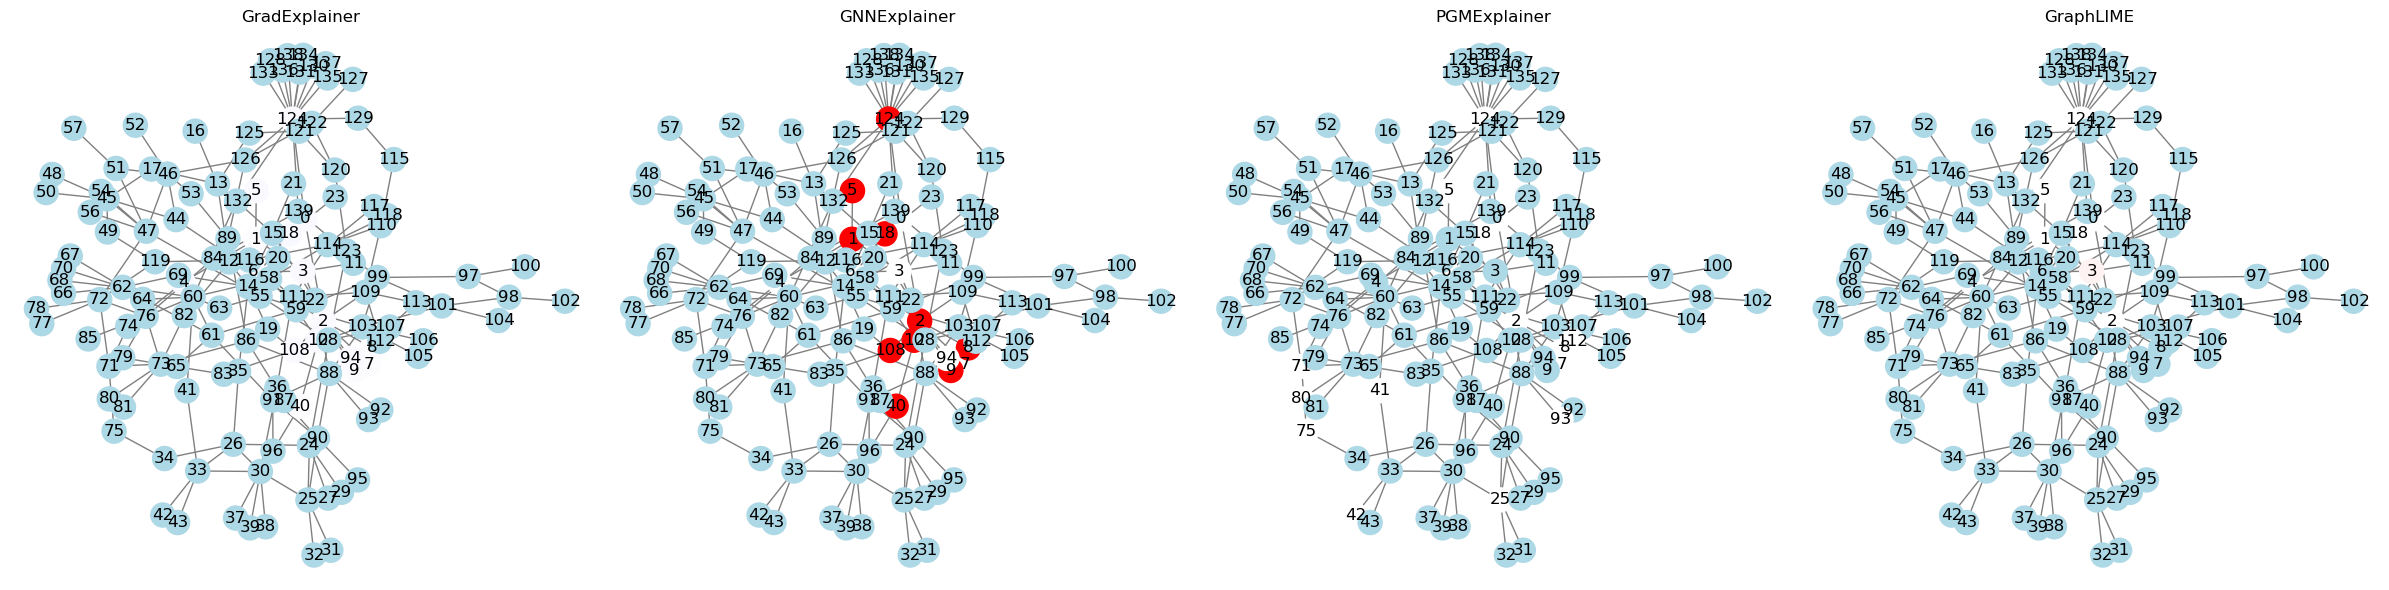

In [46]:
def plot_explanation_comparison(data, node_idx, explanations, titles):
    fig, axes = plt.subplots(1, len(explanations), figsize=(6 * len(explanations), 6))
    
    for ax, exp, title in zip(axes, explanations, titles):
        G = nx.Graph()
        edges = data.edge_index.cpu().numpy()
        for i in range(edges.shape[1]):
            G.add_edge(edges[0, i], edges[1, i])
        
        # Default warna
        num_nodes = data.x.size(0)
        node_colors = ['lightblue'] * num_nodes
        
        # Warnai node berdasarkan node importance
        if hasattr(exp, 'node_reference') and exp.node_reference is not None:
            for node, imp in exp.node_reference.items():
                if imp < len(exp.node_imp):
                    score = float(exp.node_imp[imp].cpu())
                    intensity = min(1.0, abs(score))
                    if score > 0:
                        node_colors[node] = f'#{int(255):02x}{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}'
                    else:
                        node_colors[node] = f'#{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}{int(255):02x}'
        else:
            # Jika tidak ada node_reference (GraphLIME dengan hanya satu node)
            for i, score in enumerate(exp.node_imp):
                intensity = min(1.0, abs(float(score)))
                if score > 0:
                    node_colors[i] = f'#{int(255):02x}{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}'
                else:
                    node_colors[i] = f'#{int(255*(1-intensity)):02x}{int(255*(1-intensity)):02x}{int(255):02x}'

        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, ax=ax,
                with_labels=True,
                node_color=node_colors,
                node_size=300,
                edge_color="gray")
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

from graphxai.utils import Explanation, EnclosingSubgraph

# Buat objek explanation baru untuk GraphLIME agar kompatibel dengan visualisasi
lime_exp = Explanation(
    node_imp=lime_node_importance,
    node_idx=node_idx
)

# Simulasikan seolah-olah node ke-i pada subset itu adalah node ke-X pada graph penuh
lime_exp.node_reference = {i: subset[i].item() for i in range(len(subset))}

# Tambahkan subgraph untuk keperluan visualisasi
lime_exp.set_enclosing_subgraph((subset, sub_edge_index, None, None))

# Ganti pada bagian list explainer:
explanations = [grad_explanation, gnn_explanation, pgm_explanation, lime_exp]
titles = ['GradExplainer', 'GNNExplainer', 'PGMExplainer', 'GraphLIME']

plot_explanation_comparison(data, node_idx, explanations, titles)
